<a href="https://colab.research.google.com/github/shaySitri/Cifar100/blob/main/cifar100_ass1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning - Assigment 1 - [CIFAR100](https://www.kaggle.com/datasets/fedesoriano/cifar100) <br>
Submmited By:  Ron Faygler, Tal Ben Shimon, Shay Sitri



<p> 1.   Q1 - Data Analysis </p>
<p> 2.   Q2 - CNN Model
<ul>
a. Basic CNN Model <br>
c. Improved CNN Model <br>
d. Inference-Time-Augmentation  <br>
e. New Category Addition  <br>
</ul> </p>
<p> 3.   Q3 - Pretrained Models (Transfer Learning)
<ul>
Basic CNN Model <br>
Improved CNN Model
</ul> </p>






# Imports

In [ ]:
!pip install -q lightning
!pip install -q neptune

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 kB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.5/481.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.9 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss
import seaborn as sns
import warnings
warnings.catch_warnings()
warnings.simplefilter("ignore")
import lightning as L
from torchvision import datasets
import torch
from torch import nn
from torchvision.transforms import ToTensor,Lambda
from torchvision import transforms as T
from torchmetrics import Accuracy
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader, random_split, Subset
from torchvision.io import read_image
from sklearn.model_selection import KFold
import PIL.Image
from io import BytesIO
import tempfile
import os
import shutil
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torchvision.models as models
from torchvision import transforms
import time
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import random
from torch.utils.data import Subset
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader
import copy
import neptune
from torchvision import datasets, transforms




In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
torch.cuda.is_available()

False

# Helpers

In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [ ]:
class drawer():
  """
   This class responsible for print data set image on the screen.
  """

  def show_images_from_selected_classes(dataset, selected_classes, num_images=5):
      class_images = {label: [] for label in selected_classes}  # Initialize dictionary for selected classes

      # Iterate through the dataset to collect images
      for idx, (_, label) in enumerate(dataset):
          if label in selected_classes:
              if len(class_images[label]) < num_images:
                  class_images[label].append(idx)

          # Break if all selected classes have enough images
          if all(len(images) == num_images for images in class_images.values()):
              break

      # Plot the images
      for class_idx in selected_classes:
          plt.figure(figsize=(15, 3))
          for i, image_idx in enumerate(class_images[class_idx]):
              image, _ = dataset[image_idx]
              plt.subplot(1, num_images, i + 1)
              plt.axis('off')
              plt.title(f'Class: {dataset.classes[class_idx]}')
              imshow(image)
          plt.show()


In [ ]:
def prepare_filtered_and_transformed_datasets(original_train_dataset, original_test_dataset, exclude_class_idx, transform=None):
    """
    Filters out the specified class index from the datasets and applies transformations.
    Adjusts the class list to reflect the removal of the class.

    Parameters:
    - original_train_dataset: The original training dataset.
    - original_test_dataset: The original test dataset.
    - exclude_class_idx: The class index to be excluded.
    - transform: The transformations to be applied to the dataset.

    Returns:
    - A tuple of (transformed_train_dataset, transformed_test_dataset)
    """
    def filter_dataset_by_class(dataset, exclude_class_idx):
        filtered_indices = [i for i, (_, label) in enumerate(dataset) if label != exclude_class_idx]
        return Subset(dataset, filtered_indices)

    class TransformedSubset(Subset):
        def __init__(self, dataset, indices, transform=None):
            super().__init__(dataset, indices)
            self.transform = transform


        def __getitem__(self, idx):
            x, y = super().__getitem__(idx)
            if self.transform:
                x = self.transform(x)
            # Adjust label indices if they are greater than the excluded index
            y = y - 1 if y > exclude_class_idx else y
            return x, y

    # Filter both training and test datasets
    filtered_train_dataset = filter_dataset_by_class(original_train_dataset, exclude_class_idx)
    filtered_test_dataset = filter_dataset_by_class(original_test_dataset, exclude_class_idx)

    # Apply transformations and adjust classes
    train_dataset_trans = TransformedSubset(original_train_dataset, filtered_train_dataset.indices, transform=transform)
    test_dataset_trans = TransformedSubset(original_test_dataset, filtered_test_dataset.indices, transform=transform)

    # Adjust the classes list
    new_classes = copy.deepcopy(original_train_dataset.classes)
    del new_classes[exclude_class_idx]

    print(f"Excluding class index: {exclude_class_idx}, Label: {original_train_dataset.classes[exclude_class_idx]}")
    print(f"New number of classes: {len(new_classes)}")

    return train_dataset_trans, test_dataset_trans, new_classes

In [ ]:
# Remain constant for all the models
batch_size = 64
data_path = './data_folder/'

# **Q1 - Data Analysis**

## Preprocess
We used CIFAR-100 (with Nati approval) after choosing Fruit-360 data set.
CIFAR 100 is already preproceesed and all the image in fixed size.

**Load CIFAR data set**



In [ ]:
train_dataset_orig = datasets.CIFAR100(root='./data', train=True, download=True, transform=ToTensor())
test_dataset_orig = datasets.CIFAR100(root='./data', train=False, download=True, transform=ToTensor())

100%|██████████| 169001437/169001437 [00:02<00:00, 63040528.83it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


We will display the data distribution among all classes.

In [ ]:
# Calculate class counts
class_counts = np.zeros(100)
for _, label in train_dataset_orig:
    class_counts[label] += 1

mean_count = np.mean(class_counts)

In [ ]:
std_dev = np.std(class_counts)
print(f"Standard Deviation: {std_dev}")
lower_bound = mean_count - std_dev
upper_bound = mean_count + std_dev

Standard Deviation: 0.0


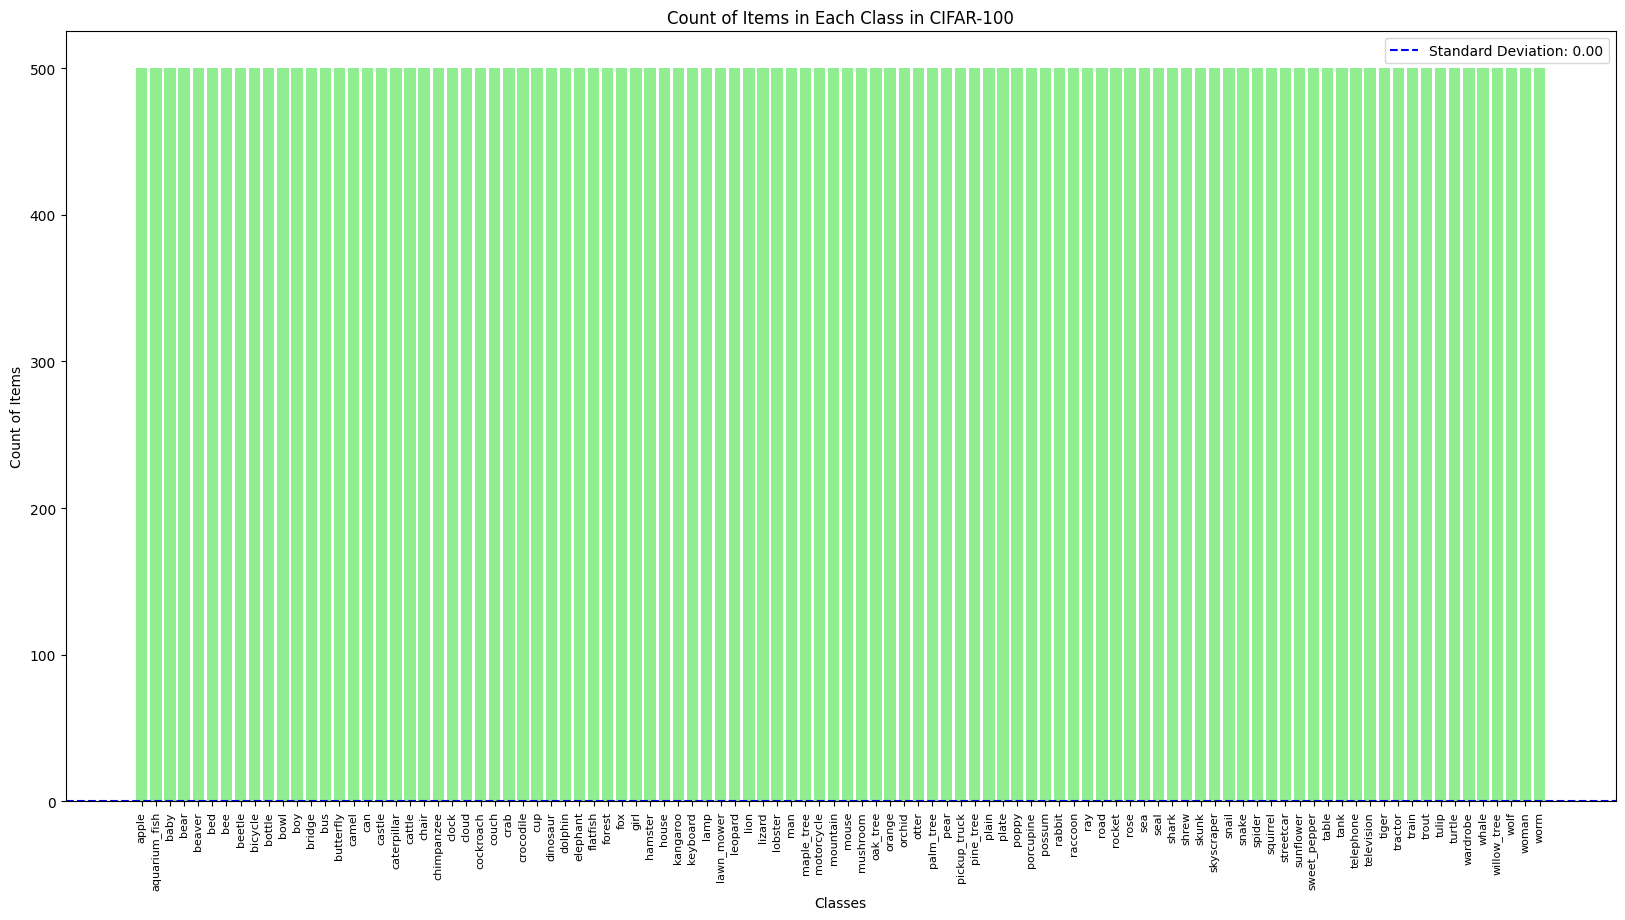

In [ ]:
# Classes
classes = train_dataset_orig.classes

# Colors for the bars
colors = ['lightgreen' if count <= upper_bound  else 'lightcoral' for count in class_counts]

# Plot
plt.figure(figsize=(20, 10))
bars = plt.bar(range(100), class_counts, color=colors)

plt.xlabel('Classes')
plt.ylabel('Count of Items')
plt.title('Count of Items in Each Class in CIFAR-100')
plt.xticks(range(100), classes, rotation='vertical', fontsize=8)
plt.axhline(y=std_dev, color='blue', linestyle='--', label=f'Standard Deviation: {std_dev:.2f}')
plt.legend()

plt.show()


Now we will display some examples of our image data:

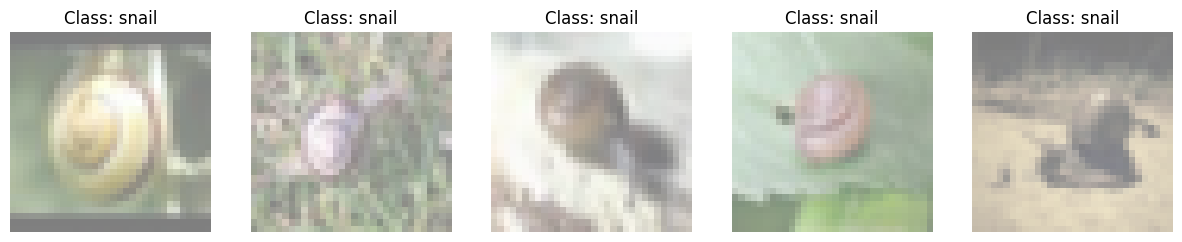

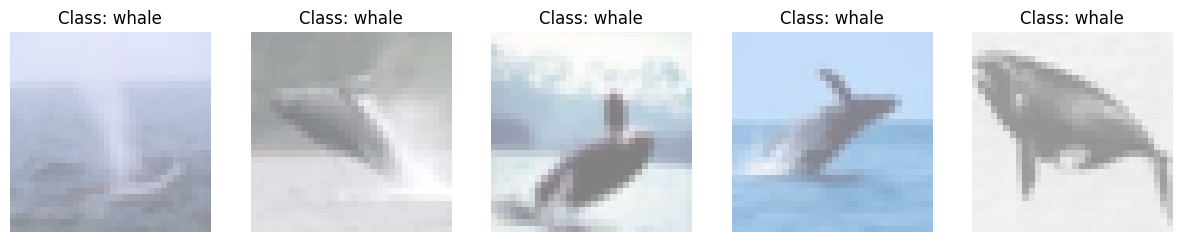

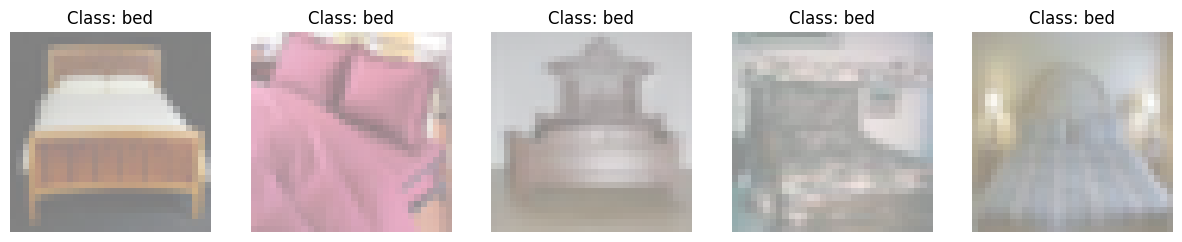

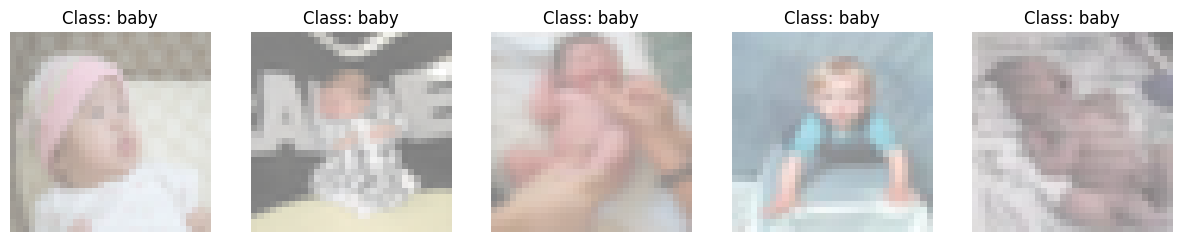

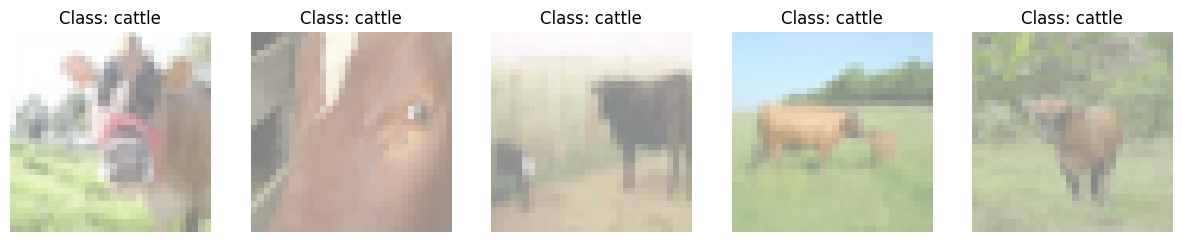

In [ ]:
# Define which classes to display (e.g., first 5 classes)
total_classes = list(range(100))

# Randomly select 5 unique classes
selected_classes = random.sample(total_classes, 5)

drawer.show_images_from_selected_classes(train_dataset_orig, selected_classes)

# **Q2 - CNN Models**

## a - Basic model <br>
**The basic model built from:** <br>
Convolutaion Layer: 3 input cahnnels, 32 output channels, 3X3 filter. <br>
Convolutaion Layer: 32 input cahnnels, 64 output channels, 3X3 filter.  <br>
Convolutaion Layer: 64 input cahnnels, 32 output channels, 3X3 filter. <br>
Convolutaion Layer: 32 input cahnnels, 64 output channels, 3X3 filter.   
Max Pooling Layer: 2X2, Stride: 2 <br>


In [ ]:
nc = 99

class CNN_CIFAR(L.LightningModule):
    def __init__(self, train,val,test, fold, learning_rate,  num_classes=nc, data_dir=data_path, batch_size=batch_size):
        super().__init__()

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.fold = fold
        self.train_dataset = train
        self.val_dataset = val
        self.test_dataset = test
        """################## Define Network Layers ##################"""
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(3, 32, 3, padding='same')
        self.conv2 = nn.Conv2d(32, 64, 3, padding='same')
        self.conv3 = nn.Conv2d(64, 32, 3, padding='same')
        self.conv4 = nn.Conv2d(32, 64, 3, padding='same')
        self.linear1 = nn.Linear(8 * 8 * 64, 150)
        self.linear2 = nn.Linear(150, self.num_classes)
        self.mp = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.fold = fold
        self.epoch = 0

        # initate train\val\test variables
        self.val_accuracy = Accuracy(task="multiclass", num_classes=nc)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=nc)
        self.train_accuracy = Accuracy(task="multiclass", num_classes=nc)
        self.val_loss = 0
        self.train_loss = 0


        self.train_output = {}
        self.validation_output = {}
        self.test_output = {}

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.mp(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.mp(x)
        x = x.view(-1, 8 * 8 * 64)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        val = F.log_softmax(x, dim=1)

        # Convert NumPy array to image before logging to Neptune
        img = PIL.Image.fromarray((val.detach().cpu().numpy() * 255).astype('uint8'))

        # Save the image to a temporary file
        with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as temp_file:
            img.save(temp_file.name, format='PNG')

        # Log the temporary file to Neptune
        run['converge'].log(neptune.types.File(temp_file.name))

        return val

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.train_accuracy.update(preds, y)
        preds_probs = F.softmax(logits, dim=1)

        # concat preds and y values from the batches of the epoch
        preds_df = pd.concat([self.train_output['preds'], pd.DataFrame(data=preds.detach().cpu().numpy())])
        self.train_output['preds'] = preds_df
        y_df = pd.concat([self.train_output['y'], pd.DataFrame(data=y.detach().cpu().numpy())])
        self.train_output['y'] = y_df

        df_batch = pd.DataFrame(data={ 'y_test': y.cpu().numpy(),
                                      'y_pred': preds.cpu().numpy(),
                                      'y_pred_probability': preds_probs.max(dim=1)[0].detach().cpu().numpy()})
        self.train_output['preds_report'] = pd.concat([self.train_output['preds_report'], df_batch])

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", self.train_accuracy, prog_bar=True)
        ## Logging to Neptune
        accuracy_value = self.train_accuracy.compute()
        run['train_loss'].append(loss.item())
        run['train_acc'].append(accuracy_value)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.val_loss = loss
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)
        preds_probs = F.softmax(logits, dim=1)

        # concat preds and y values from the batches of the epoch
        preds_df = pd.concat([self.validation_output['preds'], pd.DataFrame(data=preds.detach().cpu().numpy())])
        self.validation_output['preds'] = preds_df
        y_df = pd.concat([self.validation_output['y'], pd.DataFrame(data=y.detach().cpu().numpy())])
        self.validation_output['y'] = y_df

        df_batch = pd.DataFrame(data={'y_test': y.cpu().numpy(),
                                      'y_pred': preds.cpu().numpy(),
                                      'y_pred_probability': preds_probs.max(dim=1)[0].detach().cpu().numpy()})
        self.validation_output['preds_report'] = pd.concat([self.validation_output['preds_report'], df_batch])
        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)
        ## Logging to Neptune
        accuracy_value = self.val_accuracy.compute()
        run['val_loss'].append(loss.item())
        run['val_acc'].append(accuracy_value)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)
        preds_probs = F.softmax(logits, dim=1)
        self.test_output['preds'] = pd.concat([self.test_output['preds'], pd.DataFrame(data=preds.detach().cpu().numpy())])
        y_df = pd.concat([self.test_output['y'], pd.DataFrame(data=y.detach().cpu().numpy())])
        self.test_output['y'] = y_df
        df_batch = pd.DataFrame(data={ 'y_test': y.cpu().numpy(),
                                      'y_pred': preds.cpu().numpy(),
                                      'y_pred_probability': preds_probs.max(dim=1)[0].detach().cpu().numpy()})
        self.test_output['preds_report'] = pd.concat([self.test_output['preds_report'], df_batch])
        if batch_idx == 0:  # Initialize storage on the first batch
            self.test_results = {'images': [], 'labels': [], 'preds': []}

        # Assuming x, y, preds are tensors; detach and store
        self.test_results['images'].extend(x.cpu().detach())
        self.test_results['labels'].extend(y.cpu().detach())
        self.test_results['preds'].extend(preds.cpu().detach())
        accuracy_value = self.test_accuracy.compute()

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)

        run['test_loss'].append(loss.item())
        run['test_acc'].append(accuracy_value)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

    def on_train_epoch_start(self):\
        ## initiate train data, for calculating on the relevant inforamtion at the end of the epoch.
        print('train epoch start')
        self.train_output['preds'] = pd.DataFrame(data=[])
        self.train_output['preds_report'] = pd.DataFrame(
            data={'id': [], 'y_test': [], 'y_pred': [], 'y_pred_probability': []})
        self.train_output['y'] = pd.DataFrame(data=[])

    def on_train_epoch_end(self):
        ## calculate train metrics to neptun & csv
        report = classification_report(self.train_output['y'], self.train_output['preds'], output_dict=True)
        df_report = pd.DataFrame.from_dict(report)
        df_report.to_csv(f'train_report_{self.fold}.csv', index=False, header=True)

        run[f'train/metrics_{self.epoch}'] = neptune.types.File.as_html(df_report)
        run[f'train/predictions_epoch_{self.epoch}'] = neptune.types.File.as_html(self.train_output['preds_report'])
        self.epoch += 1
        print(f'{self.current_epoch} is done')

    def on_validation_epoch_start(self):
        ## initiate validation data, for calculating on the relevant inforamtion at the end of the epoch.
        print('validation epoch start')
        self.validation_output['preds'] = pd.DataFrame(data=[])
        self.validation_output['preds_report'] = pd.DataFrame(
            data={'id': [], 'y_test': [], 'y_pred': [], 'y_pred_probability': []})
        self.validation_output['y'] = pd.DataFrame(data=[])

    def on_validation_epoch_end(self):
        ## calculate validation metrics to neptun & csv
        report = classification_report(self.validation_output['y'], self.validation_output['preds'], output_dict=True)
        df_report = pd.DataFrame.from_dict(report)
        df_report.to_csv(f'validation_report_{self.fold}.csv', index=False, header=True)
        run[f'val/metrics_{self.epoch}'] = neptune.types.File.as_html(df_report)

    def on_test_start(self):
        ## initiate test data, for calculating on the relevant inforamtion at the end of the epoch.
        print('test epoch start')
        self.test_output['y'] = pd.DataFrame(data=[])
        self.test_output['preds'] = pd.DataFrame(data=[])
        self.test_output['preds_report'] = pd.DataFrame(
            data={'id': [], 'y_test': [], 'y_pred': [], 'y_pred_probability': []})

    def on_test_end(self):
        ## calculate validation metrics to neptun & csv
        report = classification_report(self.test_output['y'], self.test_output['preds'], output_dict=True)
        df_report = pd.DataFrame.from_dict(report)
        df_report.to_csv(f'test_report_{fold}.csv', index=False, header=True)
        run[f'test/predictions_epoch_{self.epoch}'] = neptune.types.File.as_html(self.test_output['preds_report'])
        run[f'test/metrics_{self.epoch}'] = neptune.types.File.as_html(df_report)

        images, labels, preds = self.test_results['images'], self.test_results['labels'], self.test_results['preds']

        correct_indices = [i for i, (label, pred) in enumerate(zip(labels, preds)) if label == pred]
        incorrect_indices = [i for i, (label, pred) in enumerate(zip(labels, preds)) if label != pred]

        # Randomly select two classes from correct and incorrect predictions
        correct_classes = random.sample(set(labels), 2)
        incorrect_classes = random.sample(set(labels), 2)

        def display_images(indices, title):
            plt.figure(figsize=(10, 2.5))
            plt.suptitle(title)
            for i, idx in enumerate(indices[:4]):  # Display the first 4 images
                plt.subplot(1, 4, i + 1)
                img = images[idx].permute(1, 2, 0)  # Convert CHW to HWC
                plt.imshow(img)
                plt.title(f"Label: {labels[idx]}, Pred: {preds[idx]}")
                plt.axis('off')
            plt.show()

        # Display correct predictions for selected classes
        for cls in correct_classes:
            cls_indices = [i for i in correct_indices if labels[i] == cls]
            display_images(cls_indices, f"Correctly Predicted Class {cls}")

        # Display incorrect predictions for selected classes
        for cls in incorrect_classes:
            cls_indices = [i for i in incorrect_indices if labels[i] == cls]
            display_images(cls_indices, f"Incorrectly Predicted Class {cls}")

        torch.save({
        'epoch': self.epoch,
        'model_state_dict': self.state_dict(),
        'loss': self.val_loss,
        },f"model_fold{self.fold}.pth")

        self.epoch += 1
        print(f'{self.current_epoch} is done')

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

**Model loop:** <br>
*exclude 1 class, we will ad this class on our improved model.*

In [ ]:
exclude_class_idx = 99
train_dataset, test_dataset, new_classes = prepare_filtered_and_transformed_datasets(train_dataset_orig, test_dataset_orig, exclude_class_idx, transform=None)


Excluding class index: 99, Label: worm
New number of classes: 99


https://app.neptune.ai/benshimt/fruits/e/FRUIT-167
####### START TRAINING THE MODEL  FOLD NO. 0 #######


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
   | Name           | Type               | Params
-------------------------------------------------------
0  | conv1          | Conv2d             | 896   
1  | conv2          | Conv2d             | 18.5 K
2  | conv3          | Conv2d             | 18.5 K
3  | conv4          | Conv2d             | 18.5 K
4  | linear1        | Linear             | 614 K 
5  | linear2        | Linear             | 14.9 K
6  | mp             | MaxPool2d          | 0     
7  | relu           | ReLU               | 0   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

validation epoch start


Training: |          | 0/? [00:00<?, ?it/s]

train epoch start


Validation: |          | 0/? [00:00<?, ?it/s]

validation epoch start
0 is done
train epoch start


Validation: |          | 0/? [00:00<?, ?it/s]

validation epoch start
1 is done
train epoch start


Testing: |          | 0/? [00:00<?, ?it/s]

test epoch start


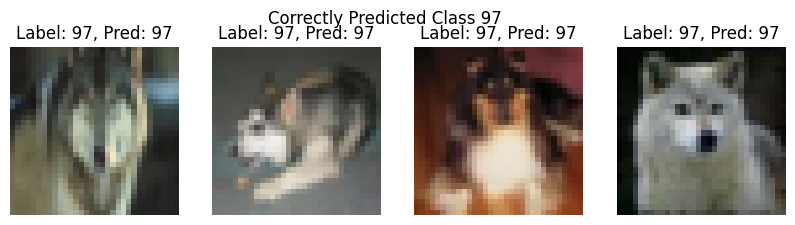

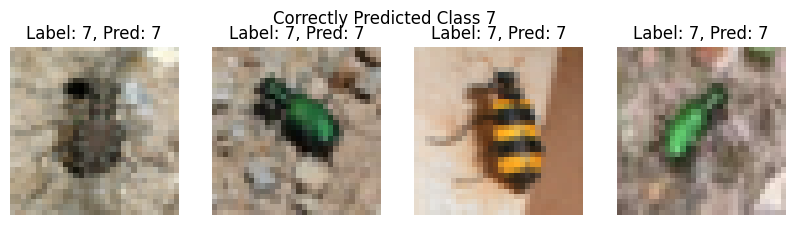

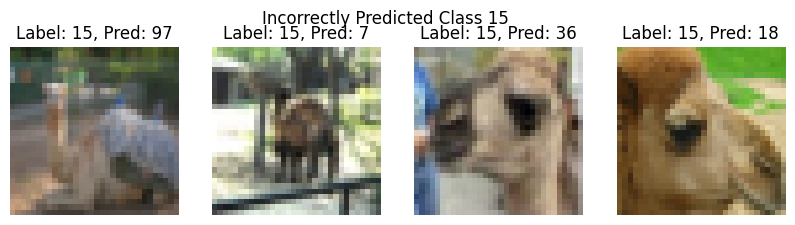

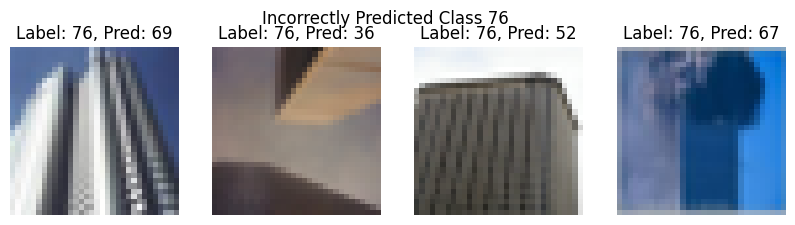

2 is done


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.1260606050491333     │
│         test_loss         │    3.8264615535736084     │
└───────────────────────────┴───────────────────────────┘

Model for fold 0 saved
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 208 operations to synchronize with Neptune. Do not kill this process.
All 208 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/benshimt/fruits/e/FRUIT-167/metadata
https://app.neptune.ai/benshimt/fruits/e/FRUIT-168


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
   | Name           | Type               | Params
-------------------------------------------------------
0  | conv1          | Conv2d             | 896   
1  | conv2          | Conv2d             | 18.5 K
2  | conv3          | Conv2d             | 18.5 K
3  | conv4          | Conv2d             | 18.5 K
4  | linear1        | Linear             | 614 K 
5  | linear2        | Linear             | 14.9 K
6  | mp             | MaxPool2d          | 0     
7  | relu           | ReLU               | 0   

####### START TRAINING THE MODEL  FOLD NO. 1 #######


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

validation epoch start


Training: |          | 0/? [00:00<?, ?it/s]

train epoch start


Validation: |          | 0/? [00:00<?, ?it/s]

validation epoch start
0 is done
train epoch start


Validation: |          | 0/? [00:00<?, ?it/s]

validation epoch start
1 is done
train epoch start


Validation: |          | 0/? [00:00<?, ?it/s]

validation epoch start
2 is done
train epoch start


Validation: |          | 0/? [00:00<?, ?it/s]

validation epoch start
3 is done
train epoch start


In [ ]:
learning_rate = 1e-4
epochs = 11
num_folds = 5

kf = KFold(n_splits=num_folds, shuffle=True, random_state=None)
# Iterate over the folds
for fold, (train_ids, test_ids) in enumerate(kf.split(train_dataset)):

    # Neptune log to each fold seperatly
    run = neptune.init_run(
        project="benshimt/fruits",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIyOGMwZDMxZi1lMTFmLTQ2OTMtODdmYi1iOTQ1MDVhMTBkMWEifQ==", # your credentials
)


    params = {"kfold": num_folds, "num_classes": nc, "batch_size": batch_size, "epochs": epochs,  "learning_rate": learning_rate,
              "optimizer": "Adam"}
    run["parameters"] = params

    # Split the dataset into training and testing sets for the current fold
    train_subsampler = Subset(train_dataset, train_ids)
    val_subsampler = Subset(train_dataset, test_ids)
    print(f'####### START TRAINING THE MODEL  FOLD NO. {fold} #######')

    model = CNN_CIFAR(train_subsampler, val_subsampler,test_dataset,fold, learning_rate)
    trainer = L.Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=epochs,
    )

    trainer.fit(model)
    trainer.test(model)

    print(f"Model for fold {fold} saved")
    run.stop()

include specific number of classes

## b - Improved Model <br>

We noticed that our first model is in **underfitting**. <br>

To improve the previous model, we addedd:

*   We complicated our model. We added max pooling layer after each convolutional layer.
* We added dropout layer (during the experiments, our model become in Overfitting).
* Increased train set with augumented images.



In [ ]:
nc = 99
class CNN_IMPROVED_CIFAR(L.LightningModule):
    def __init__(self, train,val,test, fold, learning_rate,  num_classes=nc, data_dir=data_path, batch_size=batch_size):
        super().__init__()

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.fold = fold
        self.train_dataset = train
        self.val_dataset = val
        self.test_dataset = test
        """################## Define Network Layers ##################"""
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(3, 32, 3, padding='same')
        self.conv2 = nn.Conv2d(32, 64, 3, padding='same')
        self.conv3 = nn.Conv2d(64, 128, 3, padding='same')
        self.conv4 = nn.Conv2d(128, 256, 3, padding='same')
        self.linear1 = nn.Linear(4 * 4 * 256, 512)
        self.linear2 = nn.Linear(512, self.num_classes)
        self.mp = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        self.fold = fold
        self.epoch = 0

        self.val_accuracy = Accuracy(task="multiclass", num_classes=nc)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=nc)
        self.train_accuracy = Accuracy(task="multiclass", num_classes=nc)
        self.val_loss = 0
        self.train_loss = 0


        self.train_output = {}
        self.validation_output = {}
        self.test_output = {}

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.mp(x)
        x = self.relu(self.conv2(x))
        x = self.mp(x)
        x = self.relu(self.conv3(x))
        x = self.mp(x)
        x = self.relu(self.conv4(x))
        x = self.mp(x)
        x = x.view(-1, 4 * 4 * 256)
        x = self.dropout(self.relu(self.linear1(x)))
        x = self.linear2(x)
        val = F.log_softmax(x, dim=1)

        # Convert NumPy array to image before logging to Neptune
        img = PIL.Image.fromarray((val.detach().cpu().numpy() * 255).astype('uint8'))

        # Save the image to a temporary file
        with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as temp_file:
            img.save(temp_file.name, format='PNG')

        # Log the temporary file to Neptune
        run['converge'].log(neptune.types.File(temp_file.name))

        return val

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.train_accuracy.update(preds, y)
        preds_probs = F.softmax(logits, dim=1)

        # concat preds and y values from the batches of the epoch
        preds_df = pd.concat([self.train_output['preds'], pd.DataFrame(data=preds.detach().cpu().numpy())])
        self.train_output['preds'] = preds_df
        y_df = pd.concat([self.train_output['y'], pd.DataFrame(data=y.detach().cpu().numpy())])
        self.train_output['y'] = y_df

        df_batch = pd.DataFrame(data={ 'y_test': y.cpu().numpy(),
                                      'y_pred': preds.cpu().numpy(),
                                      'y_pred_probability': preds_probs.max(dim=1)[0].detach().cpu().numpy()})
        self.train_output['preds_report'] = pd.concat([self.train_output['preds_report'], df_batch])

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", self.train_accuracy, prog_bar=True)
        ## Logging to Neptune
        accuracy_value = self.train_accuracy.compute()
        run['train_loss'].append(loss.item())
        run['train_acc'].append(accuracy_value)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.val_loss = loss
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)
        preds_probs = F.softmax(logits, dim=1)

        # concat preds and y values from the batches of the epoch
        preds_df = pd.concat([self.validation_output['preds'], pd.DataFrame(data=preds.detach().cpu().numpy())])
        self.validation_output['preds'] = preds_df
        y_df = pd.concat([self.validation_output['y'], pd.DataFrame(data=y.detach().cpu().numpy())])
        self.validation_output['y'] = y_df

        df_batch = pd.DataFrame(data={'y_test': y.cpu().numpy(),
                                      'y_pred': preds.cpu().numpy(),
                                      'y_pred_probability': preds_probs.max(dim=1)[0].detach().cpu().numpy()})
        self.validation_output['preds_report'] = pd.concat([self.validation_output['preds_report'], df_batch])
        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)
        ## Logging to Neptune
        accuracy_value = self.val_accuracy.compute()
        run['val_loss'].append(loss.item())
        run['val_acc'].append(accuracy_value)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)
        preds_probs = F.softmax(logits, dim=1)
        self.test_output['preds'] = pd.concat([self.test_output['preds'], pd.DataFrame(data=preds.detach().cpu().numpy())])
        y_df = pd.concat([self.test_output['y'], pd.DataFrame(data=y.detach().cpu().numpy())])
        self.test_output['y'] = y_df
        df_batch = pd.DataFrame(data={ 'y_test': y.cpu().numpy(),
                                      'y_pred': preds.cpu().numpy(),
                                      'y_pred_probability': preds_probs.max(dim=1)[0].detach().cpu().numpy()})
        self.test_output['preds_report'] = pd.concat([self.test_output['preds_report'], df_batch])
        if batch_idx == 0:  # Initialize storage on the first batch
            self.test_results = {'images': [], 'labels': [], 'preds': []}

        # Assuming x, y, preds are tensors; detach and store
        self.test_results['images'].extend(x.cpu().detach())
        self.test_results['labels'].extend(y.cpu().detach())
        self.test_results['preds'].extend(preds.cpu().detach())
        accuracy_value = self.test_accuracy.compute()

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)

        run['test_loss'].append(loss.item())
        run['test_acc'].append(accuracy_value)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

    def on_train_epoch_start(self):\
        ## initiate train data, for calculating on the relevant inforamtion at the end of the epoch.
        print('train epoch start')
        self.train_output['preds'] = pd.DataFrame(data=[])
        self.train_output['preds_report'] = pd.DataFrame(
            data={'id': [], 'y_test': [], 'y_pred': [], 'y_pred_probability': []})
        self.train_output['y'] = pd.DataFrame(data=[])

    def on_train_epoch_end(self):
        ## calculate train metrics to neptun & csv
        report = classification_report(self.train_output['y'], self.train_output['preds'], output_dict=True)
        df_report = pd.DataFrame.from_dict(report)
        df_report.to_csv(f'train_report_{self.fold}.csv', index=False, header=True)

        run[f'train/metrics_{self.epoch}'] = neptune.types.File.as_html(df_report)
        run[f'train/predictions_epoch_{self.epoch}'] = neptune.types.File.as_html(self.train_output['preds_report'])
        self.epoch += 1
        print(f'{self.current_epoch} is done')

    def on_validation_epoch_start(self):
        ## initiate validation data, for calculating on the relevant inforamtion at the end of the epoch.
        print('validation epoch start')
        self.validation_output['preds'] = pd.DataFrame(data=[])
        self.validation_output['preds_report'] = pd.DataFrame(
            data={'id': [], 'y_test': [], 'y_pred': [], 'y_pred_probability': []})
        self.validation_output['y'] = pd.DataFrame(data=[])

    def on_validation_epoch_end(self):
        ## calculate validation metrics to neptun & csv
        report = classification_report(self.validation_output['y'], self.validation_output['preds'], output_dict=True)
        df_report = pd.DataFrame.from_dict(report)
        df_report.to_csv(f'validation_report_{self.fold}.csv', index=False, header=True)
        run[f'val/metrics_{self.epoch}'] = neptune.types.File.as_html(df_report)

    def on_test_start(self):
        ## initiate test data, for calculating on the relevant inforamtion at the end of the epoch.
        print('test epoch start')
        self.test_output['y'] = pd.DataFrame(data=[])
        self.test_output['preds'] = pd.DataFrame(data=[])
        self.test_output['preds_report'] = pd.DataFrame(
            data={'id': [], 'y_test': [], 'y_pred': [], 'y_pred_probability': []})

    def on_test_end(self):
        ## calculate validation metrics to neptun & csv
        report = classification_report(self.test_output['y'], self.test_output['preds'], output_dict=True)
        df_report = pd.DataFrame.from_dict(report)
        df_report.to_csv(f'test_report_{fold}.csv', index=False, header=True)
        run[f'test/predictions_epoch_{self.epoch}'] = neptune.types.File.as_html(self.test_output['preds_report'])
        run[f'test/metrics_{self.epoch}'] = neptune.types.File.as_html(df_report)

        images, labels, preds = self.test_results['images'], self.test_results['labels'], self.test_results['preds']

        correct_indices = [i for i, (label, pred) in enumerate(zip(labels, preds)) if label == pred]
        incorrect_indices = [i for i, (label, pred) in enumerate(zip(labels, preds)) if label != pred]

        # Randomly select two classes from correct and incorrect predictions
        correct_classes = random.sample(set(labels), 2)
        incorrect_classes = random.sample(set(labels), 2)

        def display_images(indices, title):
            plt.figure(figsize=(10, 2.5))
            plt.suptitle(title)
            for i, idx in enumerate(indices[:4]):  # Display the first 4 images
                plt.subplot(1, 4, i + 1)
                img = images[idx].permute(1, 2, 0)  # Convert CHW to HWC
                plt.imshow(img)
                plt.title(f"Label: {labels[idx]}, Pred: {preds[idx]}")
                plt.axis('off')
            plt.show()

        # Display correct predictions for selected classes
        for cls in correct_classes:
            cls_indices = [i for i in correct_indices if labels[i] == cls]
            display_images(cls_indices, f"Correctly Predicted Class {cls}")

        # Display incorrect predictions for selected classes
        for cls in incorrect_classes:
            cls_indices = [i for i in incorrect_indices if labels[i] == cls]
            display_images(cls_indices, f"Incorrectly Predicted Class {cls}")

        torch.save({
        'epoch': self.epoch,
        'model_state_dict': self.state_dict(),
        'loss': self.val_loss,
        },f"model_fold{self.fold}.pth")

        self.epoch += 1
        print(f'{self.current_epoch} is done')

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


In [ ]:
# Resized transformation
preprocess = transforms.Compose([
    transforms.ToPILImage(),
      transforms.Resize((64, 64)),  # Resize the input image
      transforms.ToTensor(),  # Convert to a PyTorch tensor
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize pixel values
  ])

# Random-Crop transformation
preprocess_rc = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),  # Resize the input tensor
    transforms.RandomCrop((64, 64)),  # Example usage
    transforms.ToTensor(),  # Convert to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize pixel values
])

In [ ]:
exclude_class_idx = 99
# prepare new train set
train_dataset, test_dataset, new_classes = prepare_filtered_and_transformed_datasets(train_dataset_orig, test_dataset_orig, exclude_class_idx, transform=preprocess)
train_dataset_crop1, _, _ = prepare_filtered_and_transformed_datasets(train_dataset_orig, test_dataset_orig, exclude_class_idx, transform=preprocess_rc)
train_dataset_concat = ConcatDataset([train_dataset, train_dataset_crop1])

In [ ]:
learning_rate = 2e-4
epochs = 11
num_folds = 5


kf = KFold(n_splits=num_folds, shuffle=True, random_state=None)
# Iterate over the folds

# Split train_dataset
for fold, (train_ids, test_ids) in enumerate(kf.split(train_dataset_concat)):

    # Neptune log to each fold seperatly
    run = neptune.init_run(
            project="sitri/cfra",
            api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIwOGNjNWZlMS0yYzcwLTQ5MWUtYmQ2Zi03MTJiZGQwMjA0ZTIifQ==",
        # your credentials
    )

    params = {"kfold": num_folds, "num_classes": nc, "batch_size": batch_size, "epochs": epochs,  "learning_rate": learning_rate,
              "optimizer": "Adam"}
    run["parameters"] = params

    # Split the dataset into training and testing sets for the current fold
    train_subsampler = Subset(train_dataset_concat, train_ids)
    val_subsampler = Subset(train_dataset_concat, test_ids)
    print(f'####### START TRAINING THE MODEL  FOLD NO. {fold} #######')

    model = CNN_IMPROVED_CIFAR(train_subsampler, val_subsampler,test_dataset,fold, learning_rate)
    trainer = L.Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=epochs,
    )

    trainer.fit(model)
    trainer.test(model)

    print(f"Model for fold {fold} saved")
    run.stop()


Excluding class index: 99, Label: worm
New number of classes: 99


## c - Augmented Model <br>
To improve the previous model, we added: <br>
*   **Grayscale augmantion** - to check if the model knows to identify the images based on their shape and not color.
*   **Rotation of 20 degrees** - to check if the model can identify the images with a gentle position change.


### Augmantion Transformers

In [ ]:
# Load CIFAR-100 test dataset with transformations
test_dataset_aug = datasets.CIFAR100(root='./data', train=False, download=True, transform=ToTensor())
train_dataset_aug = datasets.CIFAR100(root='./data', train=True, download=True, transform=ToTensor())

In [ ]:
preprocess = transforms.Compose([
      transforms.Resize((224, 224)),  # Resize the input image
      transforms.ToTensor(),  # Convert to a PyTorch tensor
  ])
exclude_class_idx = 99
train_dataset_trans, test_dataset_trans, new_classes = prepare_filtered_and_transformed_datasets(train_dataset_aug, test_dataset_aug, exclude_class_idx, transform=preprocess)

In [ ]:
# Load CIFAR-100 test dataset with transformations
test_dataset_aug = datasets.CIFAR100(root='./data', train=False, download=True,transform=ToTensor())
train_dataset_aug = datasets.CIFAR100(root='./data', train=True, download=True, transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified


### Model Test

In [ ]:
preprocess = transforms.Compose([
      transforms.Resize((224, 224)),  # Resize the input image
      transforms.ToTensor(),  # Convert to a PyTorch tensor
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize pixel values
  ])
exclude_class_idx = 99
train_dataset_trans, test_dataset_trans, new_classes = prepare_filtered_and_transformed_datasets(train_dataset_aug, test_dataset_aug, exclude_class_idx, transform=preprocess)

Excluding class index: 99, Label: worm
New number of classes: 99


In [ ]:
# split the train dataset to train and validation
train_size = int(0.9 * len(train_dataset_trans))
validation_size = len(train_dataset_trans) - train_size

train_subset, validation_subset = random_split(train_dataset_trans, [train_size, validation_size])

# select the best model from the models created in the previous section (Improved Model)based on the minimal validation loss
min_loss = float('inf')
best_model = None

for i in range(5):
    checkpoint = torch.load(f"better1_cifar_fold{i}.pth")
    loss = checkpoint['loss']
    if loss < min_loss:
        min_loss = loss
        best_model = i

# Neptune log to each fold seperatly
run = neptune.init_run(
    project="benshimt/fruits",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIyOGMwZDMxZi1lMTFmLTQ2OTMtODdmYi1iOTQ1MDVhMTBkMWEifQ==",
)  # your credentials


# Ensure that a best model was indeed found
if best_model is not None:
    checkpoint = torch.load(f"better1_cifar_fold{best_model}.pth")
    # create instance of the best model with the new augmented test set
    model = CNN_IMPROVED_CIFAR(train_subset,validation_subset,test_dataset_trans, fold=0, learning_rate=2e-4)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    test_dataloader = DataLoader(test_dataset_trans, batch_size=4, shuffle=False)

    no_of_times_we_wanna_do_prediction_for_one_image = 5  # Change as needed

    # Initialize variables for accuracy calculation
    correct_predictions = 0
    total_predictions = 0
    to_pseudo_rgb = Lambda(lambda x: x.repeat(3, 1, 1))
    augmentations = [
        transforms.Compose([
            transforms.ToPILImage(),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            to_pseudo_rgb,
        ]),

        transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(20),
            transforms.ToTensor(),
        ])

    ]
    # Iterate over the test dataset
    for images, labels in test_dataloader:
        # Initialize final predictions
        final_predictions = torch.zeros(len(labels), 99)

        # Iterate for the specified number of prediction runs
        for j in range(no_of_times_we_wanna_do_prediction_for_one_image):
            # Perform predictions
            aug_index = j % len(augmentations)
            with torch.no_grad():
                aug_images = torch.stack([augmentations[aug_index](image) for image in images])
                preds = model(aug_images)

            # Accumulate predictions
            final_predictions += preds

        # Average predictions
        final_predictions /= no_of_times_we_wanna_do_prediction_for_one_image

        # Calculate accuracy
        predicted_labels = torch.argmax(final_predictions, dim=1)
        correct_predictions += (predicted_labels == labels).sum().item()
        total_predictions += len(labels)

    # Calculate accuracy
    accuracy = correct_predictions / total_predictions
    print("Accuracy:", accuracy)

else:
    print("No best model found.")

run.stop()

## d - New Category Addition
We choose to add to our modek new category of .....

In [ ]:
# load agin the train and test sets from CIFAR100 library
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=ToTensor())
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=ToTensor())

# split the training set to train and validation
train_size = int(0.9 * len(train_dataset))
validation_size = len(train_dataset) - train_size

# Split the dataset
train_subset, validation_subset = random_split(train_dataset, [train_size, validation_size])

# select the best model from the models created in the previous section (Improved Model)based on the minimal validation loss
min_loss = float('inf')
best_model = None

for i in range(5):
    checkpoint = torch.load(f"better1_cifar_fold{i}.pth")
    loss = checkpoint['loss']
    if loss < min_loss:
        min_loss = loss
        best_model = i

# Neptune log to each fold seperatly
run = neptune.init_run(
    project='ronfay/cifar',
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxNGU3ZTdiNi0yMWM5LTQ2ZTQtYWNkMS1jY2Y0OThhNjBhM2UifQ=="
)

# create instance of the best model with the new augmented test set
# model = CNN_CIFAR(train_subset, validation_subset,test_dataset,0)
model = CNN_IMPROVED_CIFAR(train_subset,validation_subset,test_dataset, fold=0, learning_rate=5e-4, num_classes=100)
model.load_state_dict(checkpoint['model_state_dict'])

# perform transfer learning on the model
# replace the last layer of the model with new layer holds the new number of outputs (classes)
model.linear2 = nn.Linear(model.linear2.in_features, 100)
# freeze weights of pre-trained layers
for param in model.parameters():
    param.requires_grad = False

for param in model.linear2.parameters():
    param.requires_grad = True

trainer = L.Trainer(
  accelerator="auto",
  devices=1,
  max_epochs=8,
)

trainer.fit(model)
trainer.test(model)
run.stop()

Files already downloaded and verified
Files already downloaded and verified


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
   | Name           | Type               | Params
-------------------------------------------------------
0  | conv1          | Conv2d             | 896   
1  | conv2          | Conv2d             | 18.5 K
2  | conv3          | Conv2d             | 18.5 K
3  | conv4          | Conv2d             | 18.5 K
4  | linear1        | Linear             | 614 K 
5  | linear2        | Linear             | 15.1 K
6  | mp             | MaxPool2d          | 0     
7  | relu           | ReLU               | 0   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

validation epoch start


InactiveRunException: 
[95m
----InactiveRunException----------------------------------------
[0m
It seems you are trying to log metadata to (or fetch it from) a run that was stopped (FRUIT-138).

Here's what you can do:
    - Resume the run to continue logging to it:
    https://docs.neptune.ai/logging/to_existing_object/
    - Don't invoke `stop()` on a run that you want to access. If you want to stop monitoring only,
    you can resume a run in read-only mode:
    https://docs.neptune.ai/api/connection_modes/#read-only-mode

You may also want to check the following docs pages:
    - https://docs.neptune.ai/logging/to_existing_object/
    - https://docs.neptune.ai/usage/querying_metadata/

[92mNeed help?[0m-> https://docs.neptune.ai/getting_help


# Q3 - Transfer Learning

## Preprocess

In [ ]:
# All the models we test, has the same data preprocess.
# Now, we define the transforms:

def prepare_data(transformers=None):
  """
  transformers: transformers needed for preprocess data.
  path: path to data
  labels: pd contain label for each image
  """

  train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transformers)
  test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transformers)

  train_size = int(0.9 * len(train_dataset))
  validation_size = len(train_dataset) - train_size

  # Split the dataset
  train_subset, validation_subset = random_split(train_dataset, [train_size, validation_size])

  # prepare dataloader
  train_dataloader = DataLoader(train_subset, batch_size=64, shuffle=True)
  test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)
  val_dataloader = DataLoader(validation_subset, batch_size=64, shuffle=True)

  return train_dataloader, test_dataloader, val_dataloader



## Training Step

In [ ]:
def train_model(model, train_loader, val_loader,test_loader, loss_func, optimizer, name=None, num_epochs=8):
    print("****************",name,"****************")
    start_time = time.time()

    for epoch in range(num_epochs):
        # Training
        isTrain = True
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # train loader return batch of inputs and labels

        for inputs, labels in train_loader:
            with torch.set_grad_enabled(isTrain):
              outputs = model(inputs)
              _, predicted = torch.max(outputs,1)
              loss = loss_func(outputs, labels)

              optimizer.zero_grad()
            # backword pass
              loss.backward()
              optimizer.step()

              running_loss += loss.item()

              total_train += len(labels)
              correct_train += predicted.eq(labels).sum().item()

        average_train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        # in validation step no need to update the gradiants
        with torch.no_grad():
            for inputs, labels in val_loader:
                # inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = loss_func(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()

        average_val_loss = val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {average_val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    # Test
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            # inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            test_loss += loss.item()

            predicted = nn.functional.softmax(outputs,dim=1).argmax(axis=1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()

    average_test_loss = test_loss / len(test_loader)
    test_accuracy = correct_test / total_test
    print(f'Test Loss: {average_test_loss:.4f}, Test Acc: {test_accuracy:.4f}')

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training time: {elapsed_time:.2f} seconds")
    print(f'correct predictions count = {correct_test}')
    print(f'error predictions count = {total_test-correct_test}')
    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params} parameters in the model')
    print('Training finished.')

### a - GoogleNet

In [ ]:
def googlenet(train_dataloader,val_dataloader,test_dataloader,loss_function, leraning_rate, num_classes):
  # Load pre-trained GoogLeNet
  googlenet = models.googlenet(pretrained=True)

  googlenet.fc = torch.nn.Linear(googlenet.fc.in_features, num_classes)

  optimizer = torch.optim.Adam(googlenet.parameters(), lr=leraning_rate)
  train_model(googlenet,train_dataloader,val_dataloader,test_dataloader,loss_function,optimizer,'GoogleNet')

  return googlenet

### b - ResNet18

In [ ]:
def resnet(train_dataloader,val_dataloader,test_dataloader,loss_function, leraning_rate, num_classes):
  resnet = models.resnet18(pretrained=True)

  # Modify the final fully connected layer for your task
  resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

  loss_func = nn.CrossEntropyLoss()

  optimizer = torch.optim.Adam(resnet.parameters(), lr=leraning_rate)
  train_model(resnet,train_dataloader,val_dataloader,test_dataloader,loss_func,optimizer,'ResNet18')

  return resnet


### c - Densenet

In [ ]:
def densenet(train_dataloader,val_dataloader,test_dataloader,loss_function, leraning_rate, num_classes):
  densenet = models.densenet121(pretrained=True)

  # Modify the final fully connected layer for your task
  densenet.classifier = nn.Linear(densenet.classifier.in_features, num_classes)

  optimizer = torch.optim.Adam(densenet.parameters(), lr=leraning_rate)

  train_model(densenet,train_dataloader,val_dataloader,test_dataloader,loss_function,optimizer,'DenseNet')
  return densenet


### d - VGG16

In [ ]:
def vgg(train_dataloader,val_dataloader,test_dataloader,loss_function, leraning_rate, num_classes):
  vgg = models.vgg16(pretrained=True)

  # Modify the final fully connected layer for your task
  vgg.classifier[-1] = nn.Linear(vgg.classifier[-1].in_features, num_classes)

  optimizer = torch.optim.Adam(vgg.parameters(), lr=leraning_rate)

  train_model(vgg,train_dataloader,val_dataloader,test_dataloader,loss_function,optimizer,'VGG16')
  return vgg


## Models Execution

In [ ]:
num_classes = 100
loss_func = nn.CrossEntropyLoss()
learning_rate = 0.001
trained_models = {}
preprocess = transforms.Compose([
      transforms.Resize((224, 224)),  # Resize the input image
      transforms.ToTensor(),  # Convert to a PyTorch tensor
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize pixel values
  ])

train_dataloader, test_dataloader, val_dataloader = prepare_data(preprocess)
trained_models['googlenet'] = googlenet(train_dataloader,val_dataloader,test_dataloader,loss_func, learning_rate, num_classes)
trained_models['resnet'] = resnet(train_dataloader,val_dataloader,test_dataloader,loss_func, learning_rate, num_classes)
trained_models['densenet'] = densenet(train_dataloader,val_dataloader,test_dataloader,loss_func, learning_rate, num_classes)
trained_models['vgg'] = vgg(train_dataloader,val_dataloader,test_dataloader,loss_func, learning_rate, num_classes)



## Feature Extractor and Classification

In [ ]:
def extract_features(dataloader, feature_extractor):
    features = []
    labels = []
    with torch.no_grad():
        for inputs, label_batch in dataloader:
            feature_batch = feature_extractor(inputs)
            features.append(feature_batch.flatten(1))
            labels.append(label_batch)

    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)

    return features.numpy(), labels.numpy()

In [ ]:
def classification_and_metrics(classifier,features,labels):
  predictions_probs = classifier.predict_proba(features)
  predictions = classifier.predict(features)
  # compute validation accuracy
  accuracy = accuracy_score(labels, predictions)

  # Compute validation loss
  loss = F.cross_entropy(torch.tensor(predictions_probs), torch.tensor(labels))
  report = classification_report(labels, predictions)

  return  accuracy,loss,report,predictions_probs


In [ ]:
def plot_multiclass_prediction_probabilities(predictions_probs, labels, num_classes):
    # Get the max predicted probability for each sample
    max_probs = np.max(predictions_probs, axis=1)

    # Optionally, get the predicted class for each sample for coloring
    predicted_classes = np.argmax(predictions_probs, axis=1)

    plt.figure(figsize=(12, 6))

    # Scatter plot of samples, colored by predicted class, sized by max probability
    scatter = plt.scatter(range(len(max_probs)), max_probs, c=predicted_classes, cmap='viridis', alpha=0.6, edgecolors='w', s=100)
    plt.colorbar(scatter, label='Predicted Class')
    plt.xlabel('Sample Index')
    plt.ylabel('Max Predicted Probability')
    plt.title('Max Prediction Probabilities for Multiclass Classification')
    plt.grid(True)
    plt.savefig("classifier_dist")
    plt.show()


In [ ]:
resnet = trained_models['resnet']

# Remove the last layer (fully connected layer) to use as feature extractor
feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1])

# Ensure the model is in evaluation mode
feature_extractor.eval()
svm_classifier = SVC(kernel='linear',probability=True)

# Extract training features, labels, and predictions
features_train, labels_train = extract_features(train_dataloader, feature_extractor)

features_test, labels_test = extract_features(test_dataloader, feature_extractor)

svm_classifier.fit(features_train,labels_train)
accuracy, loss, report,predictions_probs = classification_and_metrics(svm_classifier,features_test, labels_test)
plot_multiclass_prediction_probabilities(predictions_probs, labels_test, num_classes=100)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')


print(report)
